# 다양한 데이터 전처리 기법
아무 처리가 되지 않은 raw data를 넣는 것보다 전처리가 이루어진 데이터를 모델에 넣는 것이 훨씬 성능이 좋아질 것이다.

1. 결측치
2. 중복된 데이터
3. 이상치
4. 정규화
5. 원-핫 인코딩
6. 구간화

## 데이터 준비
[관세청 수출입 무역 통계][1] 에서 가공한 데이터 이용하기

[1]:https://unipass.customs.go.kr/ets/index.do 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
trade = pd.read_csv("trade.csv")
trade.head()

> 무역지수: 수출금액 - 수입금액

## 2. 결측치(Missing Data)
1. 결측치가 있는 데이터 제거하기
2. 결측치를 어떤 값으로 대체하기
- 대체할 경우 데이터마다 특성을 반영하자

In [ ]:
print('전체 데이터 수: ', len(trade))

In [ ]:
print('컬럼별 결측치 개수: ')
print(len(trade) - trade.count())

> `기타사항`은 모두 결측치임을 확인할 수 있다. <br/>
> 아무 정보가 없는 컬럼이므로 삭제하자

In [ ]:
# 결측치 있는 컬럼 삭제
trade = trade.drop('기타사항', axis=1) # axis=1: 열
trade.head()

> 결측치가 있는 행 살펴보기
- `DataFrame.isnull()`: 데이터마다 결측치 여부를 True, False로 반환하여
- `DataFrame.any(axis=1)`: 행마다 하나라도 True가 있으면 True, 아니면 False

> ✔️ (axis=1인 이유는 한 열씩 차례로 보기 때문)

In [ ]:
# isnull(): 데이터마다 결측치 여부를 True, False로 반환
trade.isnull()

In [ ]:
# any: 행마다 하나라도 True가 있으면 True, 그렇지 않으면 False를 반환
trade.isnull().any(axis=1)

In [ ]:
# 값이 True인 데이터(Null값이 하나라도 있는 데이터)만 추출해주기
trade[trade.isnull().any(axis=1)]

> index 191의 null값은 특정 값으로 대체 <br/>
> index 196, 197, 198은 결측치가 너무 많아므로 제거하는 것이 바람직하겠다.

> `dropna`: 결측치 삭제해주는 메서드
- `subset`으로 제거해줄 특정 칼럼들을 설정했는데, `how` 옵션을 'all'로 주어 선택한 컬럼 전부가 결측치인 행만 삭제하겠다는 옵션을 준다.
- `inplace` 옵션으로 해당 DatFrame 내부에서 바로 적용시키기

In [ ]:
# dropna: 결측치 삭제
trade.dropna(how='all', subset=['수출건수', '수출금액', '수입건수', '수입금액', '무역수지'], inplace=True)

# subset: 특정 컬럼 선택
# how - all: 컬럼 전부가 결측치인 행을 삭제하겠다
    # any: 하나라도 결측치면 삭제하겠t다
# inplace: 데이터프레임 내부에 바로 적용시킴

In [ ]:
trade[trade.isnull().any(axis=1)]

* 수치형 데이터 보완하기 (index 191)
1. 특정 값 지정
    - 결측치가 많은 경우 같은 값으로 대체된다면 데이터 분산이 실제보다 작아지는 문제
2. 평균, 중앙값으로 대체
    - 1번과 같은 문제
3. 다른 데이터를 이용해 예측값으로 대체
4. 시계열 특성을 가진 데이터의 경우 앞뒤 데이터를 통해 결측치 대체
    - ex) 기온 측정 결측치 -> 전후 데이터의 평균으로 보완

In [ ]:
# 위의 4번 방법을 통해 보완하기
trade.loc[[188, 191, 194]]

# [[]]: 해당 row 반환

In [ ]:
# '수출금액': 이전달, 다음달의 평균으로 채우기
trade.loc[191, '수출금액'] = (trade.loc[188, '수출금액'] + trade.loc[194, '수출금액']) / 2
trade.loc[[191]]

In [ ]:
# '무역수지': 수출금액 - 수입금액
trade.loc[191, '무역수지'] = trade.loc[191, '수출금액'] - trade.loc[191, '수입금액']
trade.loc[[191]]

* 수치형 데이터일 때는 결측치를 삭제하거나 대체함
> * 범주형 데이터의 경우는?
1. 특정 값 지정 ex. '기타', '결측'
2. 최빈값 등으로 대체
3. 다른 데이터를 이용해 예측값으로 대체
4. 시계열 데이터인 경우 앞뒤 데이터를 통해 결측치 대체

## 3. 중복된 데이터
중복된 데이터 제거하기

In [ ]:
# duplicated(): 중복된 데이터 여부 반환
trade.duplicated()

In [ ]:
trade[trade.duplicated()]

In [ ]:
trade[(trade['기간'] == '2020년 03월') & (trade['국가명'] == '중국')]

- index 186, 187이 중복되어 있다.

In [ ]:
# drop_duplicateds: 중복된 데이터 삭제
trade.drop_duplicates(inplace=True)

index 187이 삭제됨을 알 수 있다.

In [ ]:
df = pd.DataFrame({'id': ['001', '002', '003', '004', '002'],
                  'name': ['Park Yun', 'Kim Sung', 'Park Jin', 'Lee Han', 'Kim Min']})
df

> id가 002인 데이터 2개 존재
> - id가 사람마다 unique하다고 할 때, 둘 중 하나는 삭제해야 함

> index가 클수록 나중에 들어온 데이터이고, 사용자가 이름을 수정했을 때 업데이트가 되지 않고 삽입이 되어 생긴 문제라고 가정
> - id가 중복된 경우 맨 나중에 들어온 값만 남기자

In [ ]:
# keep='last'
df.drop_duplicates(subset=['id'], keep='last')

## 4. 이상치(Outlier)
: 대부분 값의 범위에서 벗어나 극단적으로 크거나 작은 값

> `z score`: $\frac{X-μ}{σ}$
> - z-score가 특정 기준을 넘는다면 이상치라 판단하자!
    

이상치를 판단한 뒤 <br/>
1. 간단하게 이상치 삭제
2. 이상치를 다른 값으로 대체
3. 결측치와 마찬가지로 다른 데이터를 활용해 예측 모델 만들어 예측값을 활용
4. binning을 통해 수치형 데이터를 범주형으로 바꿈


### z-score
이상치 데이터의 인덱스를 리턴하는 `outlier`라는 함수를 만든다.

In [ ]:
def outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col])) / np.std(df[col]) > z].index

In [ ]:
trade.loc[outlier(trade, '무역수지', 1.5)]

In [ ]:
trade.loc[outlier(trade, '무역수지', 2)]

In [ ]:
trade.loc[outlier(trade, '무역수지', 3)]

- 무역수지 이상치를 확인하는데 기준되는 값이 클수록 이상치가 적어진다는 것을 알 수 있음

In [ ]:
# 무역수지가 이상치가 값이 아닌 데이터만 추출하기
def not_outlier(df, col, z):
    return df[abs(df[col] - np.mean(df[col])) / np.std(df[col]) <= z].index

In [ ]:
trade.loc[not_outlier(trade, '무역수지', 1.5)]

### IQR method
> IQR(Interquartile range) <br/>
> $IQR = Q_3 - Q_1$ <br/>
> - $Q_1 - 1.5*IQR$ 보다 왼쪽에 있거나, $Q_3 + 1.5*IQR$ 보다 오른쪽에 있는 경우 이상치라 판단한다.

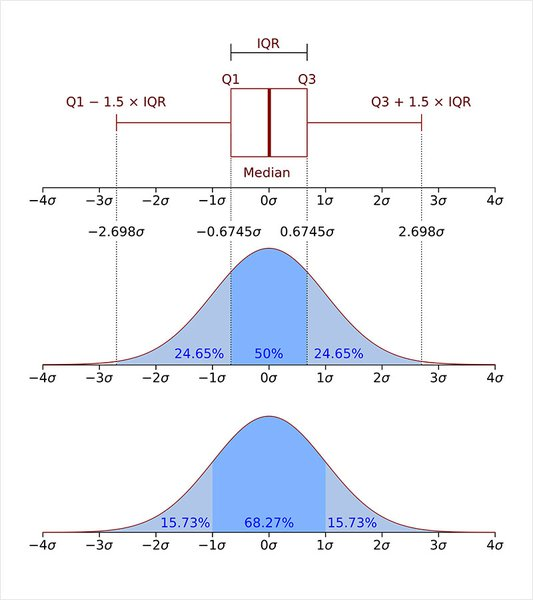

In [ ]:
np.random.seed(2020)
data = np.random.randn(100) # 평균 0, 표편 1의 분포에서 100개의 숫자를 샘플링한 데이터 생성
data = np.concatenate((data, np.array([8, 10, -3, -5]))) # [8,10,-3,-5])를 데이터 뒤에 추가
data

> - np.random.rand: 0~1 균일 분포에서 난수 matrix 생성
> - np.random.randn: 가우시안 표준 정규 분포(평균0, 표편1)에서 난수 matrix 생성

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(data)
plt.show()

In [ ]:
# 제1사분위수, 제3사분위수 구하기
Q3, Q1 = np.percentile(data, [75, 25])
IQR = Q3 - Q1
IQR

In [ ]:
# 이상치 확인하기
data[(Q1-1.5*IQR > data) | (Q3+1.5*IQR < data)]

In [ ]:
def outlier2(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    return df[(df[col] < q1-1.5*iqr) | (df[col] > q3+1.5*iqr)]

outlier2(trade, '무역수지')

> z-score의 단점**
1. 평균과 표준편차 자체가 이상치의 존재에 크게 영향을 미치기 때문에 robust하지 못하다.
2. 전체 데이터셋의 크기가 작다면 이상치를 알아내기 어렵다.

## 5. 정규화(Normalization)

In [ ]:
trade.head()

> trade 데이터를 보면 수입건수, 수출건수 & 수입금액, 수출금액, 무역수지는 단위가 다르다. <br/>

이렇게 컬럼마다 scale 차이가 있다면 머신러닝 모델 학습에 문제가 생길 수 있다. <br/>
-> 정규화를 시키자!

<br/>

- `Standardization`: 데이터의 평균=0, 분산=1 <br/>
> $ X-\frac{X-μ}{σ} $

- `Min-Max Scaling`: 데이터의 최솟값=0, 최댓값=1 <br/>
> $ \frac{X - X_{min}}{X_{max} - X_{min}} $

In [ ]:
# 정규분포를 따라 랜덤하게 데이터 x를 생성함
x = pd.DataFrame({'A': np.random.randn(100)*4+4,
                 'B': np.random.randn(100)-1})
x

In [ ]:
# Standardization
x_standardization = (x - x.mean()) / x.std()
x_standardization

In [ ]:
# Min-Max Scaling
x_min_max = (x-x.min()) / (x.max()-x.min())
x_min_max

In [ ]:
# Standardization 정규화 -> 분포 확인
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={
    'width_ratios': [2, 1]})

axs[0].scatter(x['A'], x['B'])
axs[0].set_xlim(-5, 15)
axs[0].set_ylim(-5, 5)
axs[0].axvline(c='grey', lw=1)
axs[0].axhline(c='grey', lw=1)

axs[1].scatter(x_standardization['A'], x_standardization['B'])
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].axvline(c='grey', lw=1)
axs[1].axhline(c='grey', lw=1)
axs[1].set_title('Data after standardization')

plt.show()

In [ ]:
# Min-Max Scaling 정규화 -> 분포 확인
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={
    'width_ratios': [2, 1]})

axs[0].scatter(x['A'], x['B'])
axs[0].set_xlim(-5, 15)
axs[0].set_ylim(-5, 5)
axs[0].axvline(c='grey', lw=1)
axs[0].axhline(c='grey', lw=1)

axs[1].scatter(x_min_max['A'], x_min_max['B'])
axs[1].set_xlim(-5, 5)
axs[1].set_ylim(-5, 5)
axs[1].axvline(c='grey', lw=1)
axs[1].axhline(c='grey', lw=1)
axs[1].set_title('Data after min-max scaling')

plt.show()

### 우리가 가진 trade 데이터로

In [ ]:
# trade 데이터를 Standardization 기법으로 정규화함
cols = ['수출건수', '수출금액', '수입건수', '수입금액', '무역수지']
trade_Standardization = (trade[cols]-trade[cols].mean()) / trade[cols].std()
trade_Standardization.head()


In [ ]:
trade_Standardization.describe()

- 각 컬럼의 평균은 거의 0에 가깝고, 표준편차는 1에 가까운 것을 확인할 수 있음

In [ ]:
# Min-Max Scaling
# trade 데이터를 min-max scaling 기법으로 정규화
trade[cols] = (trade[cols]-trade[cols].min()) / (trade[cols].max()-trade[cols].min())
trade.head()

In [ ]:
trade.describe()

> train 데이터를 정규화시켰던 기준 그대로 test 데이터도 정규화 시켜줘야 함

In [ ]:
train = pd.DataFrame([[10, -10], [30, 10], [50, 0]])
test = pd.DataFrame([[0, 1], [10, 10]])

In [ ]:
train_min = train.min()
train_max = train.max()

train_min_max = (train-train_min) / (train_max-train_min)
test_min_max = (test-train_min) / (train_max-train_min)

# test를 min-max scaling할 때도 train 정규화 기준으로 수행

In [ ]:
train_min_max

In [ ]:
test_min_max

In [ ]:
# scikit-learn의 StandardScaler, MinMaxScaler을 이용하는 방법도 있음
from sklearn.preprocessing import MinMaxScaler

train = [[10, -10], [30, 10], [50, 0]]
test = [[0, 1]]
scaler = MinMaxScaler()

In [ ]:
scaler.fit_transform(train)

In [ ]:
scaler.transform(test)

🥕 `fit_transform()`
> - train dataset에서만 사용
> - train data로 학습된 Scaler()의 parameter를 통해 test data의 feature 값들이 스케일 되는 것


🥕 `trasform()`
> - train data로부터 학습된 mean, varaicne 값을 test data에 적용하기 위해 transform() 메서드를 사용함
> - 여기서도 만약 fit_transform()을 사용하게 된다면 test data로부터 새로운 mean, variance 값을 얻기 때문에 이도 같이 학습되는 것이다.

> 추가로 **로그 변환**도 정규화와 함께 사용하면 도움이 됨

## 6. 원-핫 인코딩 (One-Hot Encoding)
: 카테고리별 이진 특성을 만들어 해당하는 특성만 1, 나머지는 0으로 만드는 방법

In [ ]:
# get_dummies 함수로 쉽게 원-핫 인코딩 수행 가능

# trade 데이터의 국가명 컬럼 원본
print(trade['국가명'].head())

# get_dummies를 통해 국가명 원-핫 인코딩
country = pd.get_dummies(trade['국가명'])
country.head()

In [ ]:
# pd.concat으로 trade와 country 합쳐주기
trade = pd.concat([trade, country], axis=1)
trade.head()

- axis=1 : 열
- axis=0 : 행

In [ ]:
# 필요 없어진 국가명 컬럼 삭제해주기
trade.drop(['국가명'], axis=1, inplace=True)
trade.head()

## 7. 구간화(Binning)

> 데이터를 구간별로 나누기: 구간화(`Data binning` 혹은 `bucketing`)
> - 히스토그램과 같이 연속적인 데이터를 구간을 나눠 분석할 때 사용하는 방법

- salary에 소득 데이터가 있다고 하자.

In [ ]:
salary = pd.Series([4300, 8370, 1750, 3830, 1840, 4220, 3020, 2290, 4740, 4600, 
                    2860, 3400, 4800, 4470, 2440, 4530, 4850, 4850, 4760, 4500, 
                    4640, 3000, 1880, 4880, 2240, 4750, 2750, 2810, 3100, 4290, 
                    1540, 2870, 1780, 4670, 4150, 2010, 3580, 1610, 2930, 4300, 
                    2740, 1680, 3490, 4350, 1680, 6420, 8740, 8980, 9080, 3990, 
                    4960, 3700, 9600, 9330, 5600, 4100, 1770, 8280, 3120, 1950, 
                    4210, 2020, 3820, 3170, 6330, 2570, 6940, 8610, 5060, 6370,
                    9080, 3760, 8060, 2500, 4660, 1770, 9220, 3380, 2490, 3450, 
                    1960, 7210, 5810, 9450, 8910, 3470, 7350, 8410, 7520, 9610, 
                    5150, 2630, 5610, 2750, 7050, 3350, 9450, 7140, 4170, 3090])

In [ ]:
salary.hist()

> pandas의 `cut`과 `qcut`을 이용해 수치형 데이터 -> 범주형 데이터로 변형시키기

In [ ]:
# 먼저 구간 정해주기
bins = [0, 2000, 4000, 6000, 8000, 10000]

In [ ]:
# cut 함수에 데이터와 구간을 입력 -> 데이터를 구간별로 나눠줌
ctg = pd.cut(salary, bins=bins)
ctg

In [ ]:
print('salary[0]: ', salary[0])
print('salary[0]이 속한 카테고리: ', ctg[0])

In [ ]:
# value_counts(): 구간 별로 값이 몇 개가 속해있는지
ctg.value_counts().sort_index()

> `cut` 함수: 데이터와 구간을 입력하면 데이터를 구간별로 나눠줌 <br/>
> - 위와 같이 특정 구간을 지정해주는 게 아니라, 구간의 개수를 지정해주기

In [ ]:
# 구간의 개수 지정해줄 수도 있음
ctg = pd.cut(salary, bins=6)
ctg

In [ ]:
ctg.value_counts().sort_index()

> `qcut`: 구간을 일정하게 나누는게 아니라 데이터의 분포를 비슷한 크기의 그룹으로 나누기

In [ ]:
ctg = pd.qcut(salary, q=5)
ctg

In [ ]:
print(ctg.value_counts().sort_index())
print('.\n.\n Well done')